# Libraries

In [39]:
import numpy as np
import pandas as pd
import operator
from copy import deepcopy
from math import log
from anytree import Node, RenderTree

# Load Data

In [2]:
filepath = './data/spliceATrainKIS.dat'
data = []

In [3]:
with open(filepath) as fp:
    line = fp.readline()
    cnt = 1
    while line:
        data.append(line.strip())
        line = fp.readline()
        cnt += 1

In [4]:
cutNr = int(data[0])

In [5]:
cutNr

68

In [6]:
data = data[1:]

In [7]:
data = np.reshape(a=data, newshape=(int(11576/2), 2))

In [8]:
df = pd.DataFrame(data, columns=['y', "seq"])

In [9]:
df.y = pd.to_numeric(df.y)
classes = list(df.y)

In [10]:
attributes = set("".join([i for i in df.seq]))

In [11]:
sequences = np.array([list(i) for i in df.seq])

In [12]:
attributes


{'A', 'C', 'G', 'N', 'S', 'T'}

# Filotrowanie N i S

In [13]:
def filterLetter(data, sequences):
    dataTemporal = deepcopy(data)
    idxsN = [idx   for  idx, sequence in enumerate(sequences) if np.where(sequence=='N')[0].size]
    idxsS = [idx   for  idx, sequence in enumerate(sequences) if np.where(sequence=='S')[0].size]
    indices = np.concatenate((idxsN, idxsS))
    for i in sorted(np.unique(indices), reverse=True):
        del dataTemporal[i]
#     np.save('test.npy', data)
    print(len(dataTemporal))
    return dataTemporal
# data2 = np.load('test.npy')

In [14]:
dataF = filterLetter(list(data), sequences)
dfF = pd.DataFrame(dataF, columns=['y', "seq"])
dfF.y = pd.to_numeric(dfF.y)
classesF = list(dfF.y)
attributesF = set("".join([i for i in dfF.seq]))
sequencesF = np.array([list(i) for i in dfF.seq])

5768


In [15]:
data = dataF
df = dfF
classes = classesF
attributes = attributesF
sequences = sequencesF

In [16]:
attributes

{'A', 'C', 'G', 'T'}

# Algorytm 

zbiór klas 'c'- czy jest prawdziwy czy nie (1 & 0)

zbiór obiektów 's' - zbiór kolejnych przykładów

zbiór atrybutów poza klasą 'r'- zbiór unikalnych liter

## częstość i-tej klasy

In [33]:
def countFrequencyClasses(sequences, attributes):
    p = [{c: 0 for c in attributes} for i in range(sequences.shape[1])]
    n = deepcopy(p)
    pAn = deepcopy(p)
    for ridx, row in enumerate(sequences):
        for cidx, column in enumerate(row):
            pAn[cidx][column] += 1
            if df.y[ridx] == 1:
                p[cidx][column] += 1
            else:
                n[cidx][column] += 1
    return p, n, pAn

mam zliczoną ilość wystąpień klejnych klas w danych numerach algorytmu

## atrybut maksimalizujący infGain

### entropia zbioru

In [35]:
def calculate_frequency(pAn):
    """
    p = list of dictionaries caunting positive
    n - list of dictionaries counting negative
    y - output (0, 1)
    """
    totalInRow = [sum(row.values()) for row in pAn]
    frequencies = deepcopy(pAn)
    for row, rowSum in zip(frequencies, totalInRow):
        for key in row:
            row[key] = row[key]/rowSum
    return frequencies

In [37]:
def calculate_entropyLabel(labels):
    p = 0
    n = 0
    for ridx, row in enumerate(labels):
        if row == 1:
            p += 1
        else:
            n += 1
    pf = p/len(labels)
    nf = n/len(labels)
    entropy = -pf*log(pf, 2)-nf*log(nf, 2)
    return entropy

policzyc entropy dla outlook z przykładu zeby sprawdzic dzialanie

In [36]:
def singleEntropy(f, nrF):
    """
    Funkcja liczy entropie dla pojedynczego podzbioru cechy
    """
    return -f*log(f, nrF)
def entropy(e1, e2, *rest):
    """
    liczy entropie dla cechy
    """
    args = np.concatenate(([e1, e2], rest)).astype(float) 
    fs = [arg/sum(args) for arg in args]
    return sum([singleEntropy(f, len(fs)) for f in fs])

In [26]:
def informationGain(class1, class2, feature):
    #licze entropie E(S)
    es = entropy(class1, class2)
#     if not rest:
#         eArgsP = np.array([e1pair, e2pair]).astype(float)
#     else:
#         eArgsP = np.concatenate(([e1pair, e2pair], rest)).astype(float)
    eArgsP = np.array(feature).astype(float)
    # sumuje pozytywne i negatywne w eArgs
    eArgs = [sum(e) for e in eArgsP]
    #licze czestotliwosci 
    fs = [arg/sum(eArgs) for arg in eArgs]
    fsAtributes = [[value/sum(attribute) for value in attribute] for attribute in eArgsP]
    #licze entropie dla calosci
    entropies = [entropy(value[0], value[1]) for value in fsAtributes]
    return es-sum([entropy*f for f, entropy in zip(fs, entropies)])

In [38]:
def getPairsPosNeg(p, n):
    #biore pary pobry/zly z poszczególnych cech i ich mozliwych opcji
    ePairs = []
    keys = p[0].keys()
    for featureP, featureN in zip(p, n):
        ePair = [(featureP[key], featureN[key]) for key in keys]
        ePairs.append(ePair)
    return ePairs

In [21]:
def id3(classes, attributes, sequences):
    """
    c- list of classes
    r- list of atributes
    s- list of objects
    """
#     if not sequences:
#         return -1
#     if classes.count(classes[0]) == len(x):
#         return classes[0]
#     if not attributes:
#         stats = {label: list(classes).count(label)  for label in np.unique(classes)}
#         max(stats.items(), key=operator.itemgetter(1))[0]
    #atrybut maksymalizujący InfGain(D, S)
    p, n, pAn = countFrequencyClasses(sequences, attributes)
    frequencies = calculate_frequency(pAn)
    entropyL = calculate_entropyLabel(classes)
    #licze liczebnosc klas dobre/zle (target)
    class1 = classes.count(1)
    class2 = classes.count(0)
    ePairs = getPairsPosNeg(p, n)
    infGains = [informationGain(class1, class2, pair) for pair in ePairs  ]
    #NaN wrzucają się tam, gdzie danej litery nie ma. Trzeba to potem jakos lepiej ogarnac
    informationGainR = np.nan_to_num(informationGainResults)
    #znajdz atrybut (nukleodyt), ktory ma najwiekszy InformationGain
    infGainLead = np.where(informationGainR == np.amax(informationGainR))
    #stworz drzewo
    s0 = Node(infGainLead)
    #podziel dane wg s0 i znowu policz InformationGain

In [69]:
result = np.where(informationGainR == np.amax(informationGainR))
print(result)
np.amax(informationGainR)


(array([67]),)


0.16704801144108694

# Wyjasnienie dzialania entropii

In [21]:
import numpy as np
from math import log
import matplotlib.pyplot as plt
zakres = np.linspace(0,1).astype(float)
zakres[0] = 0.0000001

In [23]:
y = [i*log(i, 2) for i in zakres]

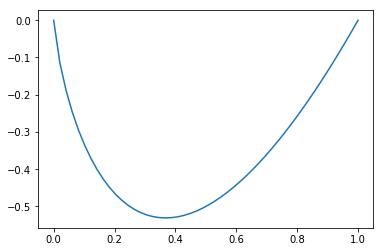

In [24]:
plt.plot(zakres, y)